In [4]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
api_key = 'haWzm6Ujj0SdpaCeCBiyyAvTvS78odvplgl4W9t29CVgSq5LrAHpt940JYQCt5TD'
secret_key = 'SgoyFqlJ6SvCYSXPFsU1ehPzQHhsfFV3Pa5scLF6y0stOO0aYXpfig6Fy4N0ePWX'
client = Client(api_key=api_key, api_secret=secret_key, tld='com')
account = client.get_account()

In [5]:

def get_history(symbol, interval, start, end=None):
    bars = client.get_historical_klines(
        symbol=symbol, interval=interval, start_str=start, end_str=end)
    df = pd.DataFrame(bars)
    df['Date'] = pd.to_datetime(df.iloc[:, 0], unit='ms')
    df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Clos Time', 'Quote Asset Volume',
                  'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore', 'Date']
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df.set_index('Date', inplace=True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

timestamp = client._get_earliest_valid_timestamp(
    symbol='BTCUSDT', interval='1d')


data = get_history('BTCUSDT', '1h', timestamp)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44242 entries, 2017-08-17 04:00:00 to 2022-09-08 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    44242 non-null  float64
 1   High    44242 non-null  float64
 2   Low     44242 non-null  float64
 3   Close   44242 non-null  float64
 4   Volume  44242 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [8]:
data['returns'] = np.log(data.Close / data.Close.shift(1))
data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2022-09-08 16:00:00,19250.81,19263.16,19093.13,19189.80,14205.332260,-0.003174
2022-09-08 17:00:00,19189.78,19246.26,19118.46,19199.28,12777.606900,0.000494
2022-09-08 18:00:00,19198.57,19246.68,19168.00,19201.24,9962.241080,0.000102


In [26]:
def backtest(data, parameters, tc): # (data, (90,5,20), 0.01)

    # prepare features
    data = data[["Close", "Volume", "returns"]].copy()
    data['vol_ch'] = np.log(data.Volume.div(data.Volume.shift(1)))
    data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
    data.loc[data.vol_ch < -3, "vol_ch"] = np.nan

    # define trading positions

    return_thresh = np.percentile(data.returns.dropna(), parameters[0])
    cond1 = data.returns >= return_thresh
    volume_thresh = np.percentile(data.vol_ch.dropna(), [parameters[1], parameters[2]])
    cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])

    data["position"] = 1
    data.loc[cond1 & cond2, "position"] = 0

    # backtest

    data["strategy"] = data.position.shift(1) * data["returns"]
    data["trades"] = data.position.diff().fillna(0).abs()
    data.strategy = data.strategy + data.trades * tc
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

    # return strategy multiple
    return data.cstrategy[-1]

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
backtest(data = data, parameters = (90, 5, 20), tc = -0.00085)

6.096440052734242

In [33]:
return_range = range(85, 98, 1) # potential val for return_thresh
vol_low_range = range(2, 16, 1) # portential val for vol_low
vol_high_range = range(16, 35, 1) # potential val for vol_high

In [34]:
list(return_range)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]

In [35]:
from itertools import product

combinations = list(product(return_range,vol_low_range,vol_high_range))

len(combinations)

3458

In [36]:
results = []

for comb in combinations:
    results.append(backtest(data = data, parameters= comb,tc = -0.00085))

In [39]:
many_results = pd.DataFrame(data = combinations, columns = ["returns","vol_low","vol_high"])
many_results["performance"] = results
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,5.184924
1,85,2,17,5.057463
2,85,2,18,5.454963
3,85,2,19,5.114396
4,85,2,20,4.706287
...,...,...,...,...
3453,97,15,30,4.482723
3454,97,15,31,4.824084
3455,97,15,32,4.396124
3456,97,15,33,4.107194


In [40]:
many_results.nlargest(20,"performance")

,returns,vol_low,vol_high,performance
2595,94,12,27,9.961368
2842,95,11,27,9.774013
2576,94,11,27,9.717974
2846,95,11,31,9.666346
2823,95,10,27,9.513945
2861,95,12,27,9.501154
2596,94,12,28,9.434685
2827,95,10,31,9.409144
2865,95,12,31,9.396493
2557,94,10,27,9.389677


In [41]:
many_results.nsmallest(20,"performance")

,returns,vol_low,vol_high,performance
18,85,2,34,2.171125
37,85,3,34,2.219556
17,85,2,33,2.245884
265,85,15,34,2.247466
36,85,3,33,2.295982
264,85,15,33,2.324853
56,85,4,34,2.336293
75,85,5,34,2.354888
94,85,6,34,2.395501
14,85,2,30,2.415119


<AxesSubplot:xlabel='returns'>

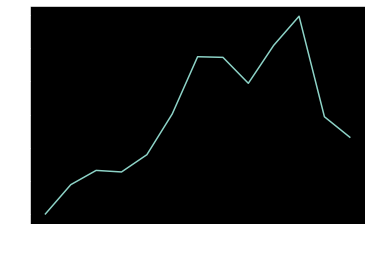

In [42]:
many_results.groupby("returns").performance.mean().plot()

<AxesSubplot:xlabel='vol_low'>

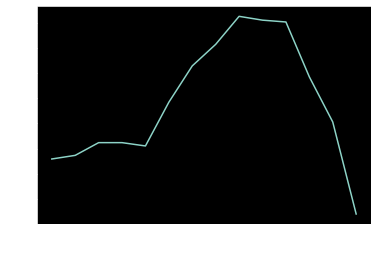

In [43]:
many_results.groupby("vol_low").performance.mean().plot()


<AxesSubplot:xlabel='vol_high'>

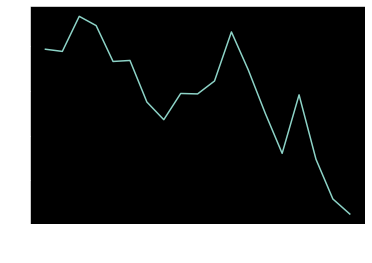

In [44]:
many_results.groupby("vol_high").performance.mean().plot()


In [49]:
backtest(data = data, parameters=(94,11,27), tc= -0.00085)

9.717973672704627

In [52]:
# vs default strat
backtest(data = data, parameters=(90,5,20), tc= -0.00085)

6.096440052734242